# Mod 2 - Project 2
## Graduation Rate Prediction Model for NYC Schools

In [46]:
# Import Libraries
#!/usr/bin/env python

import pandas as pd
from sodapy import Socrata
import sqlite3
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from functools import reduce
import missingno as msno
import seaborn as sns
import scipy as sp
from sklearn.linear_model import LinearRegression
%matplotlib inline
from matplotlib import style
style.use('ggplot')

url = "data.cityofnewyork.us"

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata(url, None)

# Results below are returned as JSON from API / converted to Python list of
# dictionaries by sodapy.

# 2005 - 2011 Graduation Outcomes - School Level - - Gender
gg_results = client.get("khqi-x3p3", limit=200000)
gg_df = pd.DataFrame.from_records(gg_results)

# 2005 - 2011 Graduation Outcomes - School Level - - Ethnicity
ge_results = client.get("6jad-5sav", limit=200000)
ge_df = pd.DataFrame.from_records(ge_results)

# 2005 - 2011 Graduation Outcomes - School Level - Classes of - Total Cohort
gtc_results = client.get("cma4-zi8m", limit=200000)
gtc_df = pd.DataFrame.from_records(gtc_results)

print(gg_df.shape)
print(ge_df.shape)
print(gtc_df.shape)

# print(gg_df.columns.difference(ge_df.columns))


(15518, 24)
(26808, 24)
(8105, 23)


In [47]:
# Rename Feature Column
gg_df['gender'] = gg_df['demographic']
ge_df['ethnicity'] = ge_df['demographic']


In [48]:
# Create New Gender df
ggf_df = gg_df[['gender', 'dbn', 'cohort_year', 'cohort_category','total_grads_pct_of_cohort','total_regents_pct_of_cohort'
              ,'advanced_regents_pct_of_cohort','regents_w_o_advanced_pct_of_cohort']]
print(ggf_df.shape)
ggf_df.tail()

(15518, 8)


,gender,dbn,cohort_year,cohort_category,total_grads_pct_of_cohort,total_regents_pct_of_cohort,advanced_regents_pct_of_cohort,regents_w_o_advanced_pct_of_cohort
15513,Male,32K564,2006,4 Year August,7.00%,3.50%,0.00%,3.50%
15514,Male,32K564,2006,5 Year June,13.50%,6.30%,0.00%,6.30%
15515,Male,32K564,2006,5 Year August,14.40%,6.30%,0.00%,6.30%
15516,Male,32K564,2007,4 Year June,7.60%,3.00%,0.00%,3.00%
15517,Male,32K564,2007,4 Year August,7.60%,3.00%,0.00%,3.00%


In [49]:
# Create New Ethnicity df
gef_df = ge_df[['ethnicity', 'dbn', 'cohort_year', 'cohort_category','total_grads_pct_of_cohort','total_regents_pct_of_cohort'
              ,'advanced_regents_pct_of_cohort','regents_w_o_advanced_pct_of_cohort']]
print(gef_df.shape)
gef_df.tail()

(26808, 8)


,ethnicity,dbn,cohort_year,cohort_category,total_grads_pct_of_cohort,total_regents_pct_of_cohort,advanced_regents_pct_of_cohort,regents_w_o_advanced_pct_of_cohort
26803,White,32K564,2006,4 Year August,s,s,s,s
26804,White,32K564,2006,5 Year June,s,s,s,s
26805,White,32K564,2006,5 Year August,s,s,s,s
26806,White,32K564,2007,4 Year June,s,s,s,s
26807,White,32K564,2007,4 Year August,s,s,s,s


In [50]:
# Create New Total Cohort df for Target Variable
gtc_df = gtc_df[['dbn', 'cohort_year', 'cohort_category','total_grads_pct_of_cohort']]
print(gtc_df.shape)
gtc_df.tail()

(8105, 4)


,dbn,cohort_year,cohort_category,total_grads_pct_of_cohort
8100,32K564,2006,4 Year August,7.80%
8101,32K564,2006,5 Year June,11.10%
8102,32K564,2006,5 Year August,12.30%
8103,32K564,2007,4 Year June,4.00%
8104,32K564,2007,4 Year August,4.00%


In [51]:
# Combine all Graduation Outcome Dataframes
# Columns for join
join_cols = ['dbn', 'cohort_year', 'cohort_category']

# Columns for features
feat_cols = [col for col in gg_df.columns if ('pct' or 'Pct') in col]
feat_cols

ffeat_cols = ['total_grads_pct_of_cohort','total_regents_pct_of_cohort'
              ,'advanced_regents_pct_of_cohort','regents_w_o_advanced_pct_of_cohort']
              
# Merge DFs and Rename resulting columns while preserving target variable 
gof_df = ggf_df.merge(gef_df, left_on=join_cols, right_on=join_cols, how='outer', suffixes=('_by_gender', '_by_ethnicity'))
gof_df = gtc_df.merge(gof_df, left_on= join_cols, right_on=join_cols, how='outer')

print(gof_df.shape)
gof_df.tail()

(52678, 14)


,dbn,cohort_year,cohort_category,total_grads_pct_of_cohort,gender,total_grads_pct_of_cohort_by_gender,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,ethnicity,total_grads_pct_of_cohort_by_ethnicity,total_regents_pct_of_cohort_by_ethnicity,advanced_regents_pct_of_cohort_by_ethnicity,regents_w_o_advanced_pct_of_cohort_by_ethnicity
52673,32K564,2007,4 Year August,4.00%,Female,1.20%,1.20%,0.00%,1.20%,White,s,s,s,s
52674,32K564,2007,4 Year August,4.00%,Male,7.60%,3.00%,0.00%,3.00%,Asian,s,s,s,s
52675,32K564,2007,4 Year August,4.00%,Male,7.60%,3.00%,0.00%,3.00%,Black,3.80%,0.00%,0.00%,0.00%
52676,32K564,2007,4 Year August,4.00%,Male,7.60%,3.00%,0.00%,3.00%,Hispanic,4.30%,3.20%,0.00%,3.20%
52677,32K564,2007,4 Year August,4.00%,Male,7.60%,3.00%,0.00%,3.00%,White,s,s,s,s


In [52]:
# 2006 - 2012 Math Test Results - District - Gender
mg_results = client.get("qphc-zrtc", limit=200000)
mg_df = pd.DataFrame.from_records(mg_results)
print(mg_df.shape)

# 2006 - 2012 Math Test Results - District - Ethnicity
me_results = client.get("usap-qc7e", limit=200000)
me_df = pd.DataFrame.from_records(me_results)
print(me_df.shape)

(3136, 16)
(6272, 16)


In [53]:
# Rename Feature Column
mg_df['gender'] = mg_df['demographic']
me_df['ethnicity'] = me_df['demographic']

In [54]:
# Create New Gender Math df
mgf_df = mg_df[['gender', 'district', 'grade', 'year',
                'mean_scale_score', 'pct_level_3', 'pct_level_4', 'pct_level_3_and_4']]
print(mgf_df.shape)
mgf_df.tail()

(3136, 8)


,gender,district,grade,year,mean_scale_score,pct_level_3,pct_level_4,pct_level_3_and_4
3131,Male,32,All Grades,2010,670,29.6,13.5,43.1
3132,Female,32,All Grades,2011,673,35,12.6,47.6
3133,Male,32,All Grades,2011,670,34,11.2,45.2
3134,Female,32,All Grades,2012,674,36,14.2,50.2
3135,Male,32,All Grades,2012,671,34.8,13,47.8


In [55]:
# Create New Ethnicity Math df
mef_df = me_df[['ethnicity', 'district', 'grade', 'year',
                'mean_scale_score', 'pct_level_3', 'pct_level_4', 'pct_level_3_and_4']]
print(mef_df.shape)
mef_df.tail()

(6272, 8)


,ethnicity,district,grade,year,mean_scale_score,pct_level_3,pct_level_4,pct_level_3_and_4
6267,White,32,All Grades,2011,670,34.2,13.5,47.7
6268,Asian,32,All Grades,2012,695,37.2,39,76.2
6269,Black,32,All Grades,2012,673,36.3,14.5,50.8
6270,Hispanic,32,All Grades,2012,672,35.2,12.3,47.5
6271,White,32,All Grades,2012,678,34.7,20.2,54.8


In [56]:
# Columns for join
join_cols = ['district', 'grade', 'year']

# Columns for features - pre
feat_cols = [col for col in mg_df.columns if ('pct' or 'Pct') in col]

# Final Columns for features - post
ffeat_cols = ['mean_scale_score' ,'pct_level_3', 'pct_level_4', 'pct_level_3_and_4']
              

In [57]:
# Merge DFs and Rename resulting columns
mof_df = mgf_df.merge(mef_df, left_on=join_cols, right_on=join_cols, how='outer', suffixes=('_by_gender', '_by_ethnicity'))
# gof_df.drop(list(gof_df.filter(regex='_y$')), axis=1, inplace=True)
print(mof_df.shape)
mof_df.tail()

(12544, 13)


,gender,district,grade,year,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,ethnicity,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
12539,Female,32,All Grades,2012,674,36,14.2,50.2,White,678,34.7,20.2,54.8
12540,Male,32,All Grades,2012,671,34.8,13,47.8,Asian,695,37.2,39,76.2
12541,Male,32,All Grades,2012,671,34.8,13,47.8,Black,673,36.3,14.5,50.8
12542,Male,32,All Grades,2012,671,34.8,13,47.8,Hispanic,672,35.2,12.3,47.5
12543,Male,32,All Grades,2012,671,34.8,13,47.8,White,678,34.7,20.2,54.8


In [58]:
## GRADUATION OUTCOMES -> gofc_df
# Create Deep Copy
gofc_df = gof_df.copy(deep=True)

# Dedup table but keep Column header
# print(gofc_df.shape)
# gofc_df = gofc_df.drop_duplicates(keep='first')
# print(gofc_df.shape)

#Replace '0' Values in Revenue & Budget with nan
gofc_cols = gofc_df.columns.tolist()
gofc_df[gofc_cols] = gofc_df[gofc_cols].replace('s', np.nan)

# Drop rows with nan Values in feature columns
gofc_df.dropna(subset = gofc_cols, inplace=True)
print(gofc_df.shape)
gofc_df.info()


(27761, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27761 entries, 25 to 52676
Data columns (total 14 columns):
dbn                                                27761 non-null object
cohort_year                                        27761 non-null object
cohort_category                                    27761 non-null object
total_grads_pct_of_cohort                          27761 non-null object
gender                                             27761 non-null object
total_grads_pct_of_cohort_by_gender                27761 non-null object
total_regents_pct_of_cohort_by_gender              27761 non-null object
advanced_regents_pct_of_cohort_by_gender           27761 non-null object
regents_w_o_advanced_pct_of_cohort_by_gender       27761 non-null object
ethnicity                                          27761 non-null object
total_grads_pct_of_cohort_by_ethnicity             27761 non-null object
total_regents_pct_of_cohort_by_ethnicity           27761 non-null object
ad

In [59]:
## MATH OUTCOMES -> mofc_df
# Create Deep Copy
mofc_df = mof_df.copy(deep=True)
print(mofc_df.shape)

# Dedup table but keep Column header
# print(gofc_df.shape)
# gofc_df = gofc_df.drop_duplicates(keep='first')
# print(gofc_df.shape)

#Replace '0' Values with nan
mofc_cols = mofc_df.columns.tolist()
mofc_df[mofc_cols] = mofc_df[mofc_cols].replace('s', np.nan)

# Drop rows with nan Values in feature columns
mofc_df.dropna(subset = mofc_cols, inplace=True)
print(mofc_df.shape)
mofc_df.info()

(12544, 13)
(12396, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12396 entries, 0 to 12543
Data columns (total 13 columns):
gender                            12396 non-null object
district                          12396 non-null object
grade                             12396 non-null object
year                              12396 non-null object
mean_scale_score_by_gender        12396 non-null object
pct_level_3_by_gender             12396 non-null object
pct_level_4_by_gender             12396 non-null object
pct_level_3_and_4_by_gender       12396 non-null object
ethnicity                         12396 non-null object
mean_scale_score_by_ethnicity     12396 non-null object
pct_level_3_by_ethnicity          12396 non-null object
pct_level_4_by_ethnicity          12396 non-null object
pct_level_3_and_4_by_ethnicity    12396 non-null object
dtypes: object(13)
memory usage: 1.3+ MB


In [60]:
###  Below are Data Shaping & Cleanup scripts ###

# GRADUATION OUTCOMES -> gofc_df
gofc_df['district'] = gofc_df['dbn'].str.slice(stop=2)

gofc_str = ['gender',
            'dbn',
            'cohort_category',
            'ethnicity']

gofc_int = ['cohort_year', 'district']

gofc_float = ['total_grads_pct_of_cohort',
              'total_grads_pct_of_cohort_by_gender',
              'total_regents_pct_of_cohort_by_gender',
              'advanced_regents_pct_of_cohort_by_gender',
              'regents_w_o_advanced_pct_of_cohort_by_gender',
              'total_grads_pct_of_cohort_by_ethnicity',
              'total_regents_pct_of_cohort_by_ethnicity',
              'advanced_regents_pct_of_cohort_by_ethnicity',
              'regents_w_o_advanced_pct_of_cohort_by_ethnicity']

gofc_df[gofc_str] = gofc_df[gofc_str].astype(str)
gofc_df[gofc_int] = gofc_df[gofc_int].astype(int)
gofc_df[gofc_float] = gofc_df[gofc_float].replace(
    {'\%': ''}, regex=True).astype(float)
print(gofc_df.info())
print('\n\n')

# MATH OUTCOMES -> mofc_df
mofc_df = mofc_df[~mofc_df['grade'].str.contains('All Grades', na=False)]
mofc_str = ['gender',
            'ethnicity']

mofc_int = ['district',
            'grade',
            'year',
            'mean_scale_score_by_gender',
            'mean_scale_score_by_ethnicity']

mofc_float = ['pct_level_3_by_gender',
              'pct_level_4_by_gender',
              'pct_level_3_and_4_by_gender',
              'pct_level_3_by_ethnicity',
              'pct_level_4_by_ethnicity',
              'pct_level_3_and_4_by_ethnicity']

mofc_df[mofc_str] = mofc_df[mofc_str].astype(str)
mofc_df[mofc_int] = mofc_df[mofc_int].astype(int)
mofc_df[mofc_float] = mofc_df[mofc_float].replace(
    {'\%': ''}, regex=True).astype(float)
print(mofc_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27761 entries, 25 to 52676
Data columns (total 15 columns):
dbn                                                27761 non-null object
cohort_year                                        27761 non-null int64
cohort_category                                    27761 non-null object
total_grads_pct_of_cohort                          27761 non-null float64
gender                                             27761 non-null object
total_grads_pct_of_cohort_by_gender                27761 non-null float64
total_regents_pct_of_cohort_by_gender              27761 non-null float64
advanced_regents_pct_of_cohort_by_gender           27761 non-null float64
regents_w_o_advanced_pct_of_cohort_by_gender       27761 non-null float64
ethnicity                                          27761 non-null object
total_grads_pct_of_cohort_by_ethnicity             27761 non-null float64
total_regents_pct_of_cohort_by_ethnicity           27761 non-null float64
advanced

In [61]:
# Aggregate Data to District Level
## Group Grad Outcomes by district, gender, ethnicity
gogb_df = gofc_df.groupby(['district', 'gender', 'ethnicity'])['total_grads_pct_of_cohort',
        'total_grads_pct_of_cohort_by_gender',
        'total_regents_pct_of_cohort_by_gender',
        'advanced_regents_pct_of_cohort_by_gender',
        'regents_w_o_advanced_pct_of_cohort_by_gender',
        'total_grads_pct_of_cohort_by_ethnicity',
        'total_regents_pct_of_cohort_by_ethnicity',
        'advanced_regents_pct_of_cohort_by_ethnicity',
        'regents_w_o_advanced_pct_of_cohort_by_ethnicity'].mean().reset_index()

print(gogb_df.shape)
print(gogb_df.info())

(212, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 12 columns):
district                                           212 non-null int64
gender                                             212 non-null object
ethnicity                                          212 non-null object
total_grads_pct_of_cohort                          212 non-null float64
total_grads_pct_of_cohort_by_gender                212 non-null float64
total_regents_pct_of_cohort_by_gender              212 non-null float64
advanced_regents_pct_of_cohort_by_gender           212 non-null float64
regents_w_o_advanced_pct_of_cohort_by_gender       212 non-null float64
total_grads_pct_of_cohort_by_ethnicity             212 non-null float64
total_regents_pct_of_cohort_by_ethnicity           212 non-null float64
advanced_regents_pct_of_cohort_by_ethnicity        212 non-null float64
regents_w_o_advanced_pct_of_cohort_by_ethnicity    212 non-null float64
dtypes: float64(9), int64

In [62]:
# Aggregate Data to District Level
## Group Grad Outcomes by district, gender, ethnicity
mogb_df = mofc_df.groupby(['district', 'gender', 'ethnicity'])['mean_scale_score_by_gender',
        'pct_level_3_by_gender',
        'pct_level_4_by_gender',
        'pct_level_3_and_4_by_gender',
        'mean_scale_score_by_ethnicity',
        'pct_level_3_by_ethnicity',
        'pct_level_4_by_ethnicity',
        'pct_level_3_and_4_by_ethnicity'].mean().reset_index()

print(mogb_df.shape)
print(mogb_df.info())

(256, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 11 columns):
district                          256 non-null int64
gender                            256 non-null object
ethnicity                         256 non-null object
mean_scale_score_by_gender        256 non-null float64
pct_level_3_by_gender             256 non-null float64
pct_level_4_by_gender             256 non-null float64
pct_level_3_and_4_by_gender       256 non-null float64
mean_scale_score_by_ethnicity     256 non-null float64
pct_level_3_by_ethnicity          256 non-null float64
pct_level_4_by_ethnicity          256 non-null float64
pct_level_3_and_4_by_ethnicity    256 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 22.1+ KB
None


In [63]:
join_cols = ['district', 'gender', 'ethnicity']

df = gogb_df.merge(mogb_df, left_on=join_cols, right_on=join_cols, how='outer')

df_cols = ['total_grads_pct_of_cohort',
           'district',
           'gender',
           'ethnicity',
           'total_regents_pct_of_cohort_by_gender',
           'advanced_regents_pct_of_cohort_by_gender',
           'regents_w_o_advanced_pct_of_cohort_by_gender',
           'total_regents_pct_of_cohort_by_ethnicity',
           'advanced_regents_pct_of_cohort_by_ethnicity',
           'regents_w_o_advanced_pct_of_cohort_by_ethnicity',
           'mean_scale_score_by_gender',
           'pct_level_3_by_gender',
           'pct_level_4_by_gender',
           'pct_level_3_and_4_by_gender',
           'mean_scale_score_by_ethnicity',
           'pct_level_3_by_ethnicity',
           'pct_level_4_by_ethnicity',
           'pct_level_3_and_4_by_ethnicity']

df = df[df_cols]

# #Replace '0' Values with nan
# df_cols = df.columns.tolist()
# df[df_cols] = df[df_cols].replace('', np.nan)

# # Drop rows with nan Values in feature columns
df.dropna(subset=df_cols, inplace=True)

print(df.shape)
print(df.info())
df.tail()

(212, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 18 columns):
total_grads_pct_of_cohort                          212 non-null float64
district                                           212 non-null int64
gender                                             212 non-null object
ethnicity                                          212 non-null object
total_regents_pct_of_cohort_by_gender              212 non-null float64
advanced_regents_pct_of_cohort_by_gender           212 non-null float64
regents_w_o_advanced_pct_of_cohort_by_gender       212 non-null float64
total_regents_pct_of_cohort_by_ethnicity           212 non-null float64
advanced_regents_pct_of_cohort_by_ethnicity        212 non-null float64
regents_w_o_advanced_pct_of_cohort_by_ethnicity    212 non-null float64
mean_scale_score_by_gender                         212 non-null float64
pct_level_3_by_gender                              212 non-null float64
pct_level_4_by_gender    

,total_grads_pct_of_cohort,district,gender,ethnicity,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,total_regents_pct_of_cohort_by_ethnicity,advanced_regents_pct_of_cohort_by_ethnicity,regents_w_o_advanced_pct_of_cohort_by_ethnicity,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
207,77.764921,31,Male,White,60.624084,28.312565,32.313613,68.064398,33.429319,34.632984,678.761905,45.130952,25.459524,70.597619,687.119048,48.600000,31.885714,80.473810
208,50.552632,32,Female,Black,24.065789,2.421053,21.650000,20.888158,1.380263,19.507895,666.976190,44.923810,13.776190,58.707143,666.714286,45.852381,13.409524,59.252381
209,57.078704,32,Female,Hispanic,27.058333,4.034259,23.030556,25.860185,3.534259,22.323148,666.976190,44.923810,13.776190,58.707143,663.857143,42.942857,12.145238,55.083333
210,50.552632,32,Male,Black,20.343421,1.082895,19.259211,20.888158,1.380263,19.507895,663.880952,42.902381,12.597619,55.500000,666.714286,45.852381,13.409524,59.252381
211,58.237500,32,Male,Hispanic,24.659821,2.971429,21.684821,26.945536,3.804464,23.137500,663.880952,42.902381,12.597619,55.500000,663.857143,42.942857,12.145238,55.083333


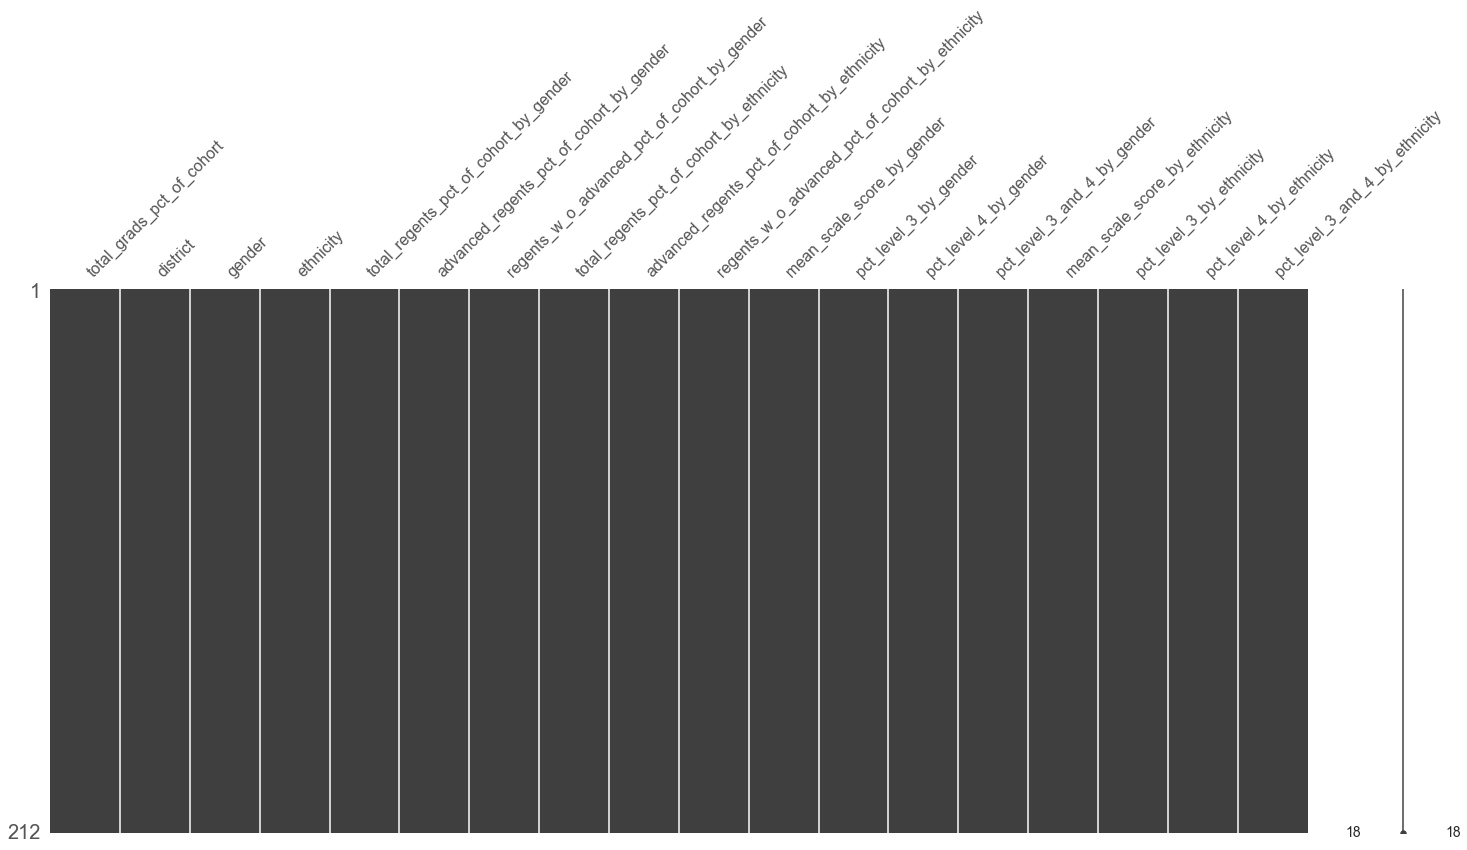

In [64]:
msno.matrix(df)

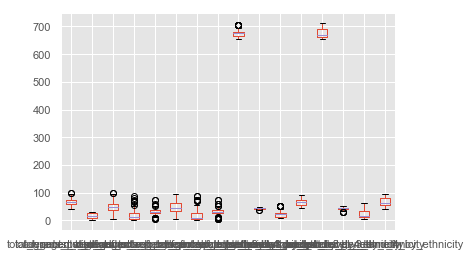

In [65]:
# pd.options.display.mpl_style = 'default'
df.boxplot()

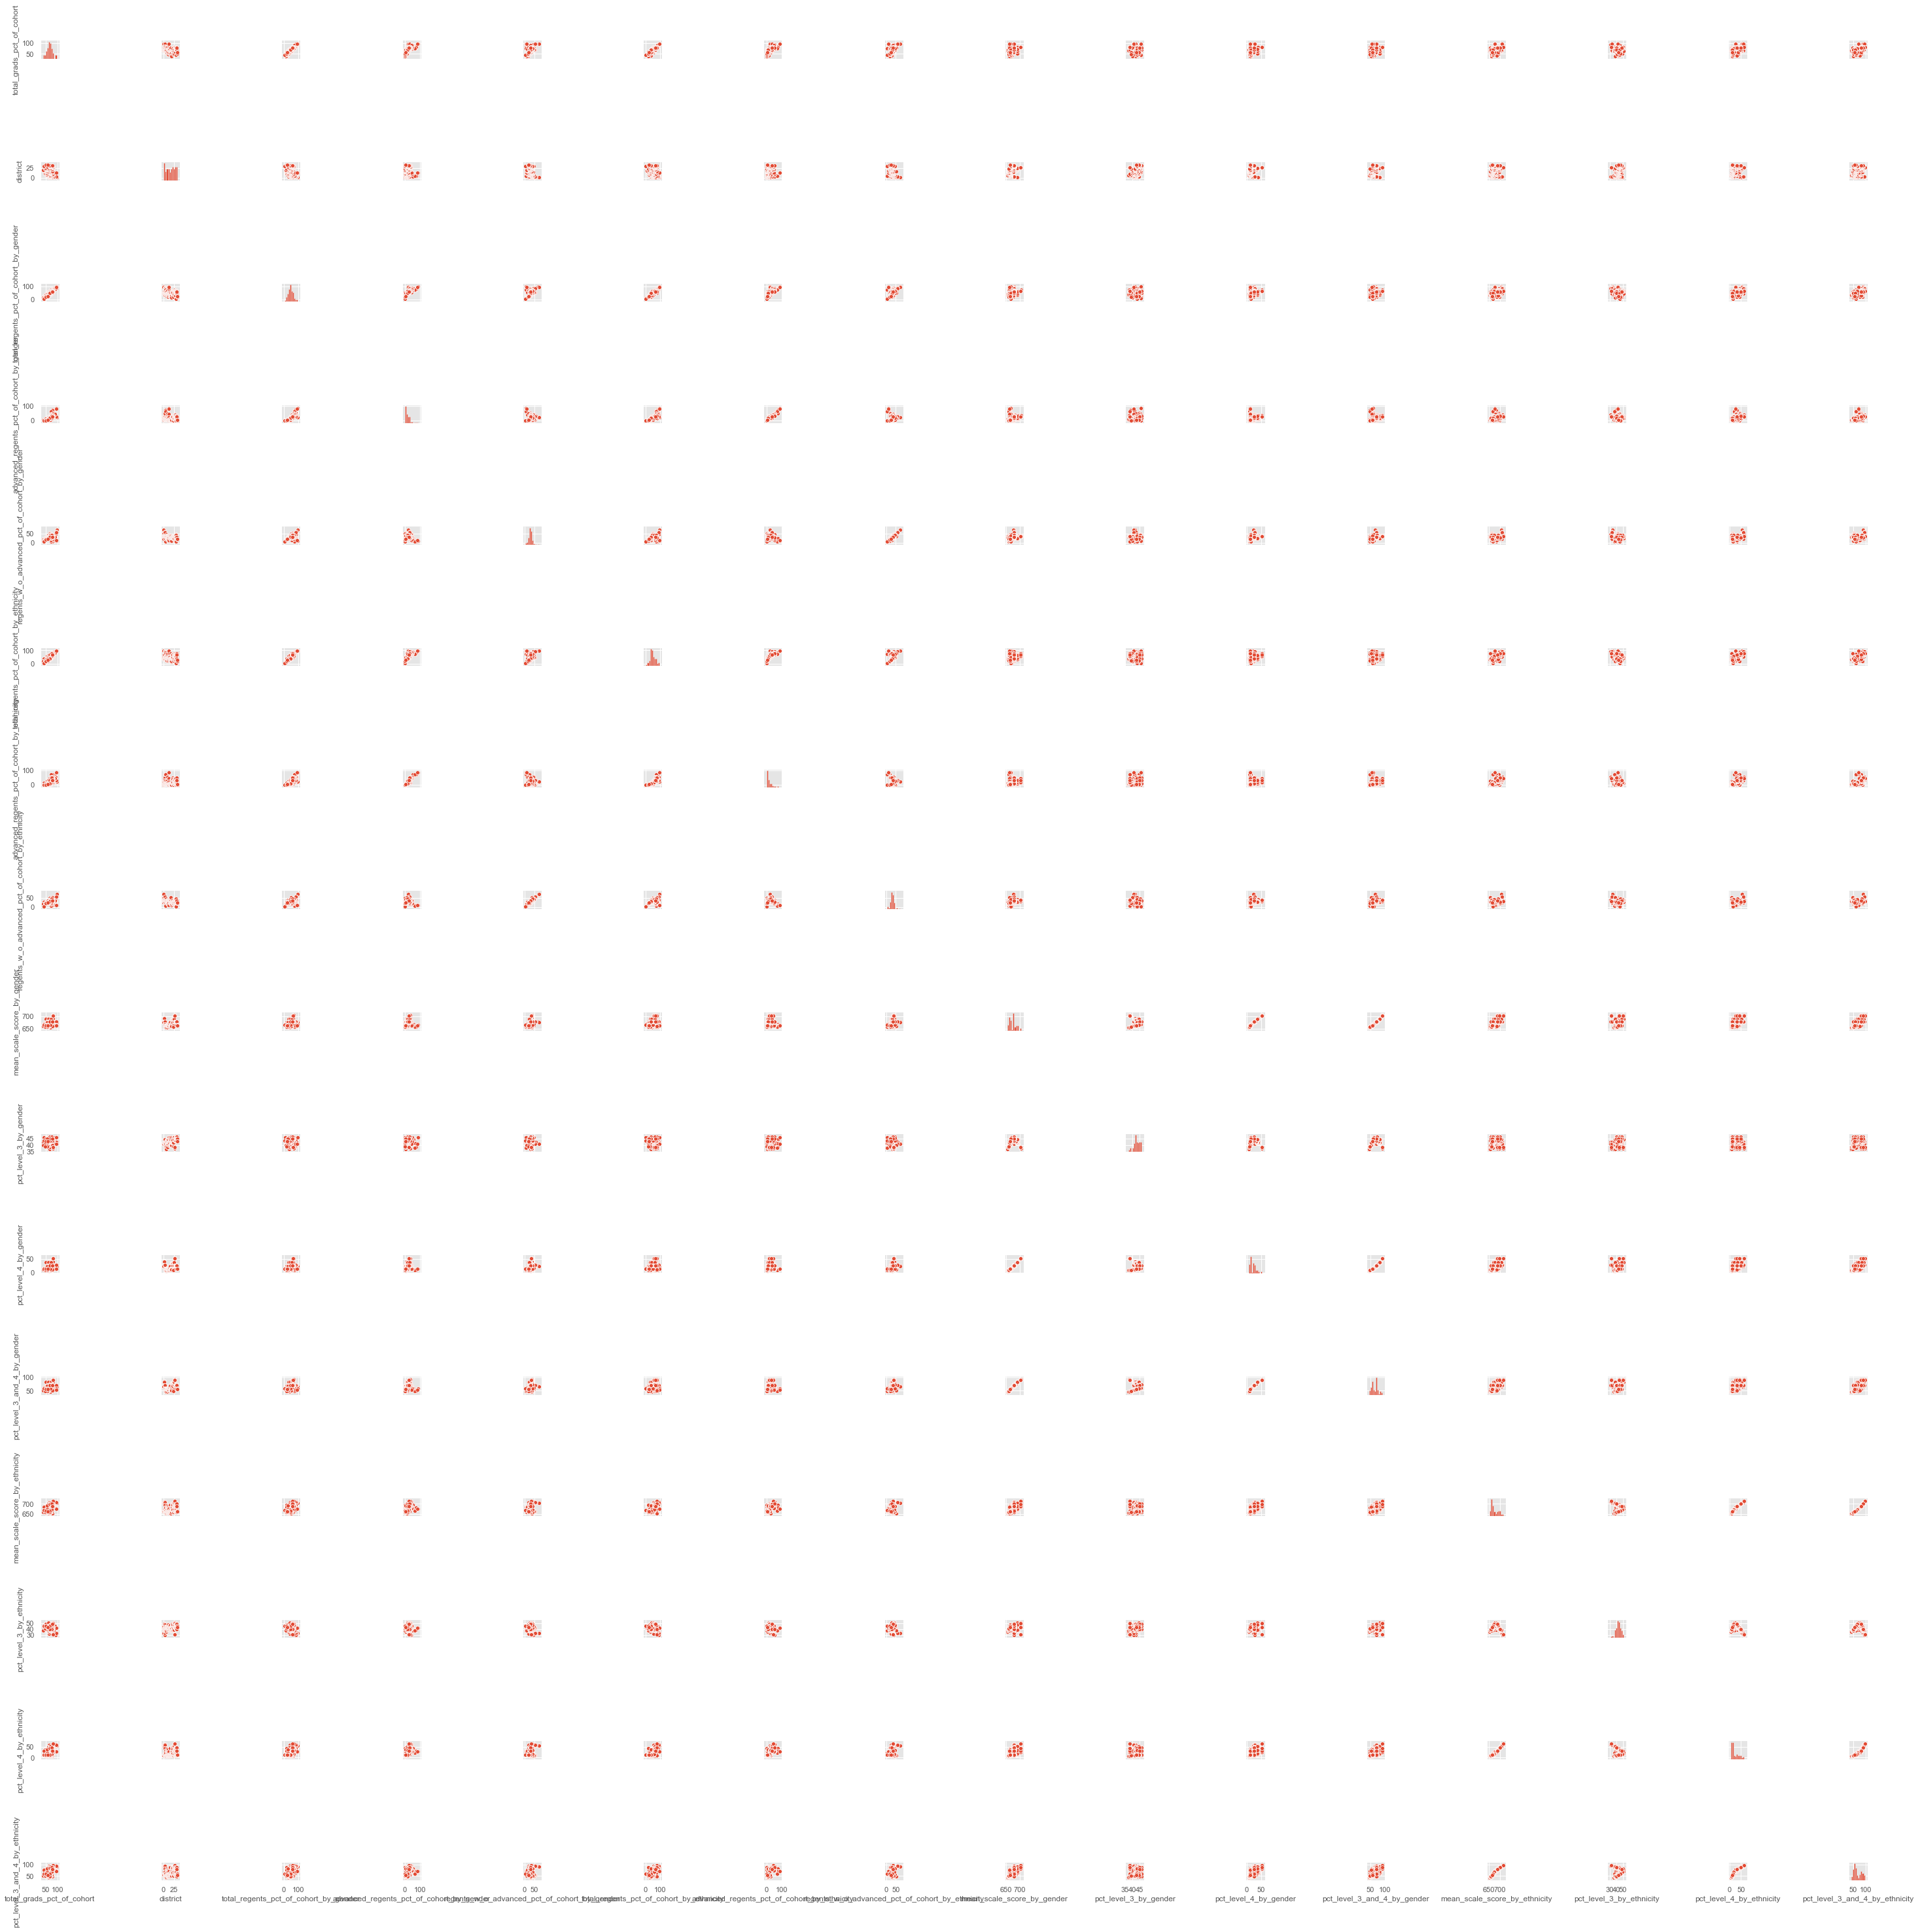

In [66]:
# pp = sns.pairplot(data=df,
#                   x_vars=['total_grads_pct_of_cohort'],
#                   y_vars=['district',
#                           'gender',
#                           'ethnicity',
#                           'total_grads_pct_of_cohort_by_gender',
#                           'total_regents_pct_of_cohort_by_gender',
#                           'advanced_regents_pct_of_cohort_by_gender',
#                           'regents_w_o_advanced_pct_of_cohort_by_gender',
#                           'total_grads_pct_of_cohort_by_ethnicity',
#                           'total_regents_pct_of_cohort_by_ethnicity',
#                           'advanced_regents_pct_of_cohort_by_ethnicity',
#                           'regents_w_o_advanced_pct_of_cohort_by_ethnicity',
#                           'mean_scale_score_by_gender',
#                           'pct_level_3_by_gender',
#                           'pct_level_4_by_gender',
#                           'pct_level_3_and_4_by_gender',
#                           'mean_scale_score_by_ethnicity',
#                           'pct_level_3_by_ethnicity',
#                           'pct_level_4_by_ethnicity',
#                           'pct_level_3_and_4_by_ethnicity']
#                   )
pp = sns.pairplot(df)
pp

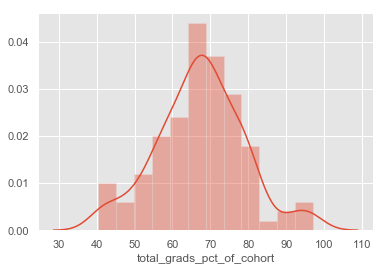

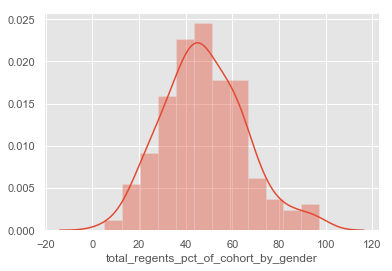

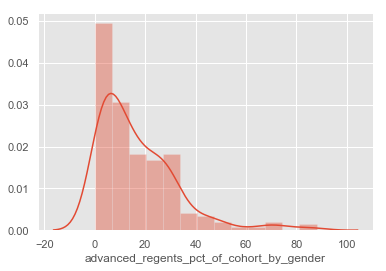

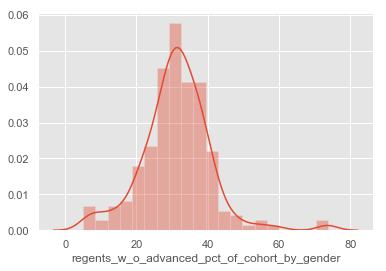

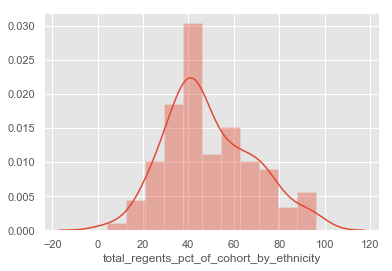

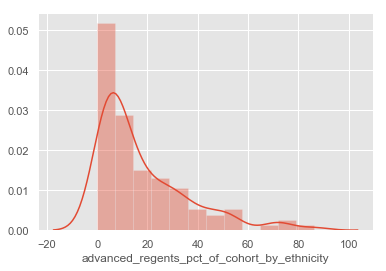

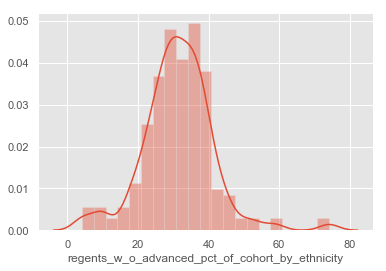

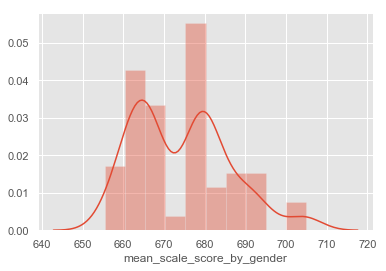

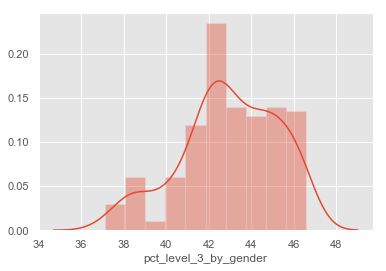

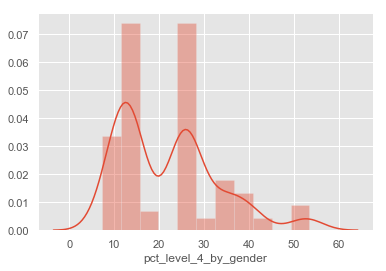

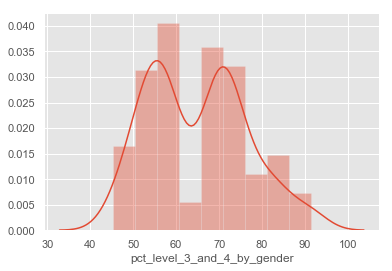

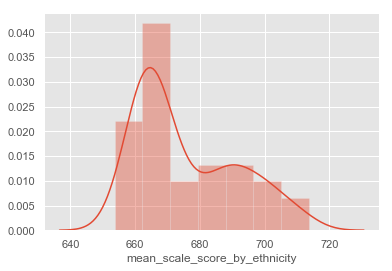

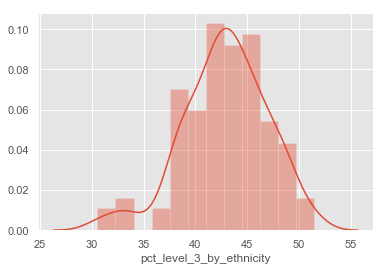

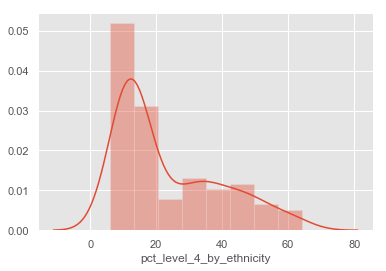

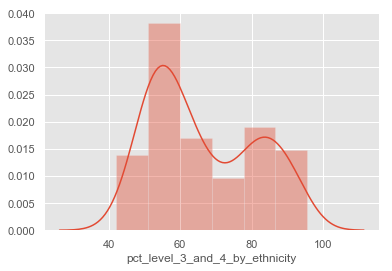

In [67]:
dfplot_cols = ['total_grads_pct_of_cohort',
 'total_grads_pct_of_cohort_by_gender',
 'total_regents_pct_of_cohort_by_gender',
 'advanced_regents_pct_of_cohort_by_gender',
 'regents_w_o_advanced_pct_of_cohort_by_gender',
 'total_grads_pct_of_cohort_by_ethnicity',
 'total_regents_pct_of_cohort_by_ethnicity',
 'advanced_regents_pct_of_cohort_by_ethnicity',
 'regents_w_o_advanced_pct_of_cohort_by_ethnicity',
 'mean_scale_score_by_gender',
 'pct_level_3_by_gender',
 'pct_level_4_by_gender',
 'pct_level_3_and_4_by_gender',
 'mean_scale_score_by_ethnicity',
 'pct_level_3_by_ethnicity',
 'pct_level_4_by_ethnicity',
 'pct_level_3_and_4_by_ethnicity']

# Histogram distributions for each variable
for i, col in enumerate(df.columns):
    if col in dfplot_cols:
#         print(i, col)
        plt.figure(i)
        sns.distplot(df[col])

In [69]:
# check for correlation

# Function for column headers to formula
df.columns
df_col = ['{}+'.format(i) for i in (list(df.columns))]
# print(''.join(df_col))

abs(df.corr()) > 0.75

,total_grads_pct_of_cohort,district,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,total_regents_pct_of_cohort_by_ethnicity,advanced_regents_pct_of_cohort_by_ethnicity,regents_w_o_advanced_pct_of_cohort_by_ethnicity,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
total_grads_pct_of_cohort,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False
district,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
total_regents_pct_of_cohort_by_gender,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False
advanced_regents_pct_of_cohort_by_gender,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False
regents_w_o_advanced_pct_of_cohort_by_gender,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
total_regents_pct_of_cohort_by_ethnicity,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False
advanced_regents_pct_of_cohort_by_ethnicity,False,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False
regents_w_o_advanced_pct_of_cohort_by_ethnicity,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
mean_scale_score_by_gender,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False
pct_level_3_by_gender,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [70]:
df.corr()

,total_grads_pct_of_cohort,district,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,total_regents_pct_of_cohort_by_ethnicity,advanced_regents_pct_of_cohort_by_ethnicity,regents_w_o_advanced_pct_of_cohort_by_ethnicity,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
total_grads_pct_of_cohort,1.000000,-0.153708,0.924040,0.713205,0.512261,0.870661,0.657649,0.475095,0.285341,-0.063532,0.293184,0.271524,0.390410,-0.220718,0.410400,0.377578
district,-0.153708,1.000000,-0.113410,-0.038075,-0.142996,-0.138905,-0.072523,-0.134506,0.335738,0.394734,0.291138,0.361878,0.094804,0.336353,0.039159,0.135749
total_regents_pct_of_cohort_by_gender,0.924040,-0.113410,1.000000,0.834953,0.452032,0.915043,0.759593,0.375447,0.356852,0.004124,0.351236,0.341402,0.459411,-0.202128,0.472507,0.449235
advanced_regents_pct_of_cohort_by_gender,0.713205,-0.038075,0.834953,1.000000,-0.113463,0.803207,0.933084,-0.152726,0.234700,0.004174,0.228023,0.221947,0.447717,-0.141019,0.464478,0.457657
regents_w_o_advanced_pct_of_cohort_by_gender,0.512261,-0.142996,0.452032,-0.113463,1.000000,0.350144,-0.141045,0.925428,0.263751,0.000682,0.264436,0.256532,0.103705,-0.136300,0.100180,0.069232
total_regents_pct_of_cohort_by_ethnicity,0.870661,-0.138905,0.915043,0.803207,0.350144,1.000000,0.857202,0.361206,0.277497,-0.047885,0.282308,0.264082,0.618301,-0.346477,0.649878,0.598742
advanced_regents_pct_of_cohort_by_ethnicity,0.657649,-0.072523,0.759593,0.933084,-0.141045,0.857202,1.000000,-0.170585,0.167596,0.003439,0.163878,0.159585,0.595509,-0.313609,0.630079,0.586681
regents_w_o_advanced_pct_of_cohort_by_ethnicity,0.475095,-0.134506,0.375447,-0.152726,0.925428,0.361206,-0.170585,1.000000,0.227546,-0.097883,0.243485,0.216376,0.104848,-0.095100,0.102658,0.083398
mean_scale_score_by_gender,0.285341,0.335738,0.356852,0.234700,0.263751,0.277497,0.167596,0.227546,1.000000,0.165377,0.992214,0.995438,0.557751,0.284958,0.483354,0.596698
pct_level_3_by_gender,-0.063532,0.394734,0.004124,0.004174,0.000682,-0.047885,0.003439,-0.097883,0.165377,1.000000,0.049091,0.248959,0.104441,0.312348,0.053998,0.144952


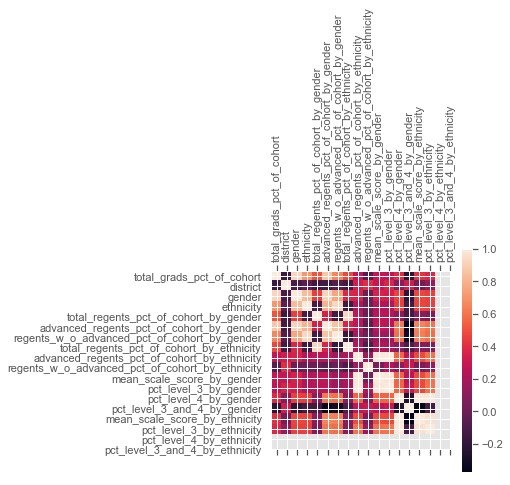

In [71]:
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

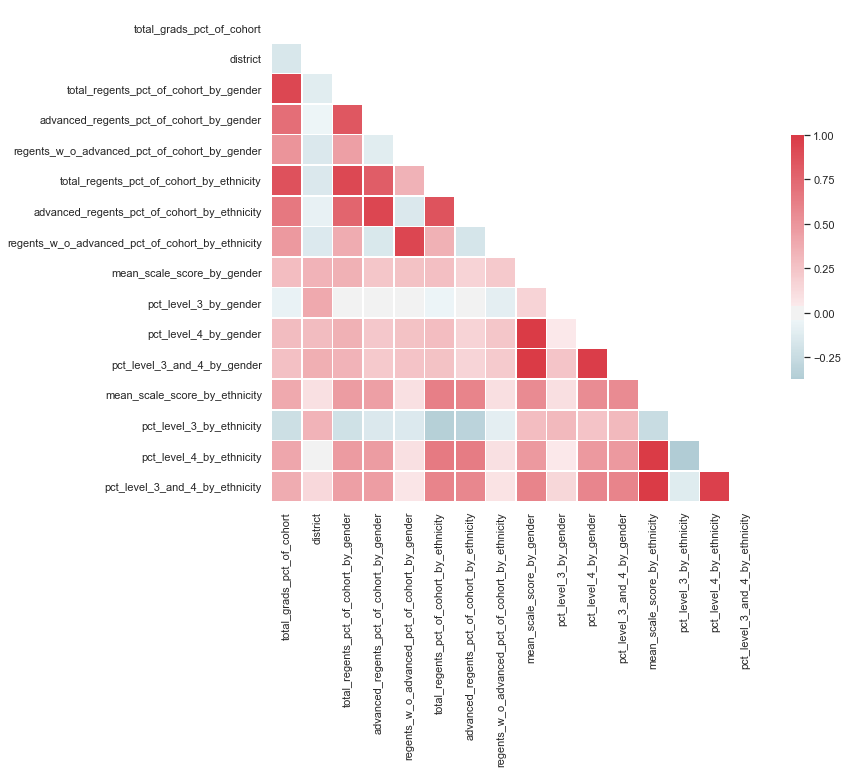

In [72]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [73]:
# Create first mlr model

f = 'total_grads_pct_of_cohort~district+gender+ethnicity+total_regents_pct_of_cohort_by_gender+advanced_regents_pct_of_cohort_by_gender+regents_w_o_advanced_pct_of_cohort_by_gender+total_regents_pct_of_cohort_by_ethnicity+advanced_regents_pct_of_cohort_by_ethnicity+regents_w_o_advanced_pct_of_cohort_by_ethnicity+mean_scale_score_by_gender+pct_level_3_by_gender+pct_level_4_by_gender+pct_level_3_and_4_by_gender+mean_scale_score_by_ethnicity+pct_level_3_by_ethnicity+pct_level_4_by_ethnicity+pct_level_3_and_4_by_ethnicity'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     total_grads_pct_of_cohort   R-squared:                       0.922
Model:                                   OLS   Adj. R-squared:                  0.914
Method:                        Least Squares   F-statistic:                     119.6
Date:                       Mon, 22 Apr 2019   Prob (F-statistic):           1.82e-95
Time:                               16:58:01   Log-Likelihood:                -548.30
No. Observations:                        212   AIC:                             1137.
Df Residuals:                            192   BIC:                             1204.
Df Model:                                 19                                         
Covariance Type:                   nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        1671.5394    413.719      4.040      0.000     855.522    2487.557
gender[T.Male]                                      3.3351      0.784      4.253      0.000       1.788       4.882
ethnicity[T.Black]                                  6.3717      1.991      3.200      0.002       2.444      10.299
ethnicity[T.Hispanic]                               7.0817      1.892      3.742      0.000       3.349      10.814
ethnicity[T.White]                                  1.0809      0.980      1.103      0.272      -0.853       3.014
district                                           -0.0157      0.032     -0.495      0.621      -0.079       0.047
total_regents_pct_of_cohort_by_gender             -27.4580     30.914     -0.888      0.376     -88.433      33.517
advanced_regents_pct_of_cohort_by_gender           28.0273     30.913      0.907      0.366     -32.945      89.000
regents_w_o_advanced_pct_of_cohort_by_gender       28.0347     30.920      0.907      0.366     -32.951      89.021
total_regents_pct_of_cohort_by_ethnicity           14.4273     36.178      0.399      0.690     -56.931      85.786
advanced_regents_pct_of_cohort_by_ethnicity       -14.3959     36.195     -0.398      0.691     -85.786      56.994
regents_w_o_advanced_pct_of_cohort_by_ethnicity   -14.2284     36.214     -0.393      0.695     -85.658      57.201
mean_scale_score_by_gender                         -0.8656      0.665     -1.301      0.195      -2.178       0.446
pct_level_3_by_gender                            -136.1746     32.912     -4.138      0.000    -201.090     -71.260
pct_level_4_by_gender                            -136.0132     32.864     -4.139      0.000    -200.834     -71.192
pct_level_3_and_4_by_gender                       136.8841     32.965      4.152      0.000      71.865     201.903
mean_scale_score_by_ethnicity                      -1.7614      0.403     -4.373      0.000      -2.556      -0.967
pct_level_3_by_ethnicity                           54.3445     30.635      1.774      0.078      -6.079     114.768
pct_level_4_by_ethnicity                           55.5267     30.630      1.813      0.071      -4.887     115.941
pct_level_3_and_4_by_ethnicity                    -53.5530     30.620     -1.749      0.082    -113.948       6.842
==============================================================================
Omnibus:                        3.505   Durbin-Watson:                   1.353
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.936
Skew:                          -0.185   Prob(JB):                        0.230
Kurtosis:             

In [74]:
# Create new df for 2nd mlr model
df2_cols = ['total_grads_pct_of_cohort',
            'gender',
            'ethnicity',
            'total_regents_pct_of_cohort_by_gender',
            'advanced_regents_pct_of_cohort_by_gender',
            'regents_w_o_advanced_pct_of_cohort_by_gender',
            'mean_scale_score_by_gender',
            'pct_level_3_by_gender',
            'pct_level_4_by_gender',
            'pct_level_3_and_4_by_gender',
            'mean_scale_score_by_ethnicity',
            'pct_level_3_by_ethnicity',
            'pct_level_4_by_ethnicity',
            'pct_level_3_and_4_by_ethnicity']


df2 = df[df2_cols]
print(df2.shape)
df2.head()


(212, 14)


,total_grads_pct_of_cohort,gender,ethnicity,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
0,65.054348,Female,Asian,49.295652,24.643478,24.652174,678.523810,41.790476,26.252381,68.040476,708.666667,33.009524,59.100000,92.100000
1,68.753947,Female,Black,55.444737,1.965789,53.478947,678.523810,41.790476,26.252381,68.040476,662.595238,42.704762,10.566667,53.269048
2,65.623009,Female,Hispanic,48.219469,6.558407,41.663717,678.523810,41.790476,26.252381,68.040476,664.952381,45.892857,11.373810,57.266667
3,97.100000,Female,White,97.350000,23.993750,73.356250,678.523810,41.790476,26.252381,68.040476,705.952381,33.795238,55.957143,89.747619
4,65.054348,Male,Asian,42.365217,20.780435,21.584783,676.071429,41.285714,24.473810,65.750000,708.666667,33.009524,59.100000,92.100000


In [76]:
# Function for column headers for 2nd mlr formula
df2.columns
df2_cols = ['{}+'.format(i) for i in (list(df2.columns))]
print(''.join(df2_cols))

total_grads_pct_of_cohort+gender+ethnicity+total_regents_pct_of_cohort_by_gender+advanced_regents_pct_of_cohort_by_gender+regents_w_o_advanced_pct_of_cohort_by_gender+mean_scale_score_by_gender+pct_level_3_by_gender+pct_level_4_by_gender+pct_level_3_and_4_by_gender+mean_scale_score_by_ethnicity+pct_level_3_by_ethnicity+pct_level_4_by_ethnicity+pct_level_3_and_4_by_ethnicity+


In [77]:
# 2nd mlr Model
f = 'total_grads_pct_of_cohort~gender+ethnicity+total_regents_pct_of_cohort_by_gender+advanced_regents_pct_of_cohort_by_gender+regents_w_o_advanced_pct_of_cohort_by_gender+mean_scale_score_by_gender+pct_level_3_by_gender+pct_level_4_by_gender+pct_level_3_and_4_by_gender+mean_scale_score_by_ethnicity+pct_level_3_by_ethnicity+pct_level_4_by_ethnicity+pct_level_3_and_4_by_ethnicity'
mod2 = ols(formula=f, data=df2).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     total_grads_pct_of_cohort   R-squared:                       0.920
Model:                                   OLS   Adj. R-squared:                  0.913
Method:                        Least Squares   F-statistic:                     149.3
Date:                       Mon, 22 Apr 2019   Prob (F-statistic):           1.96e-98
Time:                               16:58:21   Log-Likelihood:                -551.68
No. Observations:                        212   AIC:                             1135.
Df Residuals:                            196   BIC:                             1189.
Df Model:                                 15                                         
Covariance Type:                   nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     1785.5466    399.416      4.470      0.000     997.842    2573.251
gender[T.Male]                                   3.9161      0.679      5.770      0.000       2.578       5.255
ethnicity[T.Black]                               4.9742      1.806      2.755      0.006       1.413       8.536
ethnicity[T.Hispanic]                            5.3240      1.647      3.232      0.001       2.076       8.572
ethnicity[T.White]                               0.6334      0.886      0.715      0.475      -1.114       2.380
total_regents_pct_of_cohort_by_gender          -31.6056     30.834     -1.025      0.307     -92.415      29.204
advanced_regents_pct_of_cohort_by_gender        32.1933     30.834      1.044      0.298     -28.615      93.002
regents_w_o_advanced_pct_of_cohort_by_gender    32.3955     30.834      1.051      0.295     -28.413      93.204
mean_scale_score_by_gender                      -0.8710      0.649     -1.342      0.181      -2.151       0.409
pct_level_3_by_gender                         -142.5992     32.631     -4.370      0.000    -206.951     -78.247
pct_level_4_by_gender                         -142.3480     32.570     -4.371      0.000    -206.580     -78.116
pct_level_3_and_4_by_gender                    143.2200     32.693      4.381      0.000      78.744     207.696
mean_scale_score_by_ethnicity                   -1.9327      0.399     -4.845      0.000      -2.719      -1.146
pct_level_3_by_ethnicity                        55.5919     30.717      1.810      0.072      -4.987     116.170
pct_level_4_by_ethnicity                        56.8035     30.710      1.850      0.066      -3.762     117.369
pct_level_3_and_4_by_ethnicity                 -54.6671     30.702     -1.781      0.077    -115.215       5.881
==============================================================================
Omnibus:                        3.524   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.919
Skew:                          -0.180   Prob(JB):                        0.232
Kurtosis:                       2.552   Cond. No.                     1.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# Create df for 3rd mrl model
df3_cols = ['total_grads_pct_of_cohort',
            'pct_level_3_by_gender',
            'pct_level_4_by_gender',
            'pct_level_3_and_4_by_gender',
            'mean_scale_score_by_ethnicity',
            'pct_level_3_by_ethnicity',
            'pct_level_4_by_ethnicity',
            'pct_level_3_and_4_by_ethnicity']

df3 = df[df3_cols]
print(df3.shape)
df3.head()

(212, 8)


,total_grads_pct_of_cohort,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
0,65.054348,41.790476,26.252381,68.040476,708.666667,33.009524,59.100000,92.100000
1,68.753947,41.790476,26.252381,68.040476,662.595238,42.704762,10.566667,53.269048
2,65.623009,41.790476,26.252381,68.040476,664.952381,45.892857,11.373810,57.266667
3,97.100000,41.790476,26.252381,68.040476,705.952381,33.795238,55.957143,89.747619
4,65.054348,41.285714,24.473810,65.750000,708.666667,33.009524,59.100000,92.100000


In [79]:
# Function for column headers to formula
df3.columns
df3_cols = ['{}+'.format(i) for i in (list(df3.columns))]
print(''.join(df3_cols))

total_grads_pct_of_cohort+pct_level_3_by_gender+pct_level_4_by_gender+pct_level_3_and_4_by_gender+mean_scale_score_by_ethnicity+pct_level_3_by_ethnicity+pct_level_4_by_ethnicity+pct_level_3_and_4_by_ethnicity+


In [80]:
# 3rd mlr Model

f = 'total_grads_pct_of_cohort~pct_level_3_by_gender+pct_level_4_by_gender+pct_level_3_and_4_by_gender+mean_scale_score_by_ethnicity+pct_level_3_by_ethnicity+pct_level_4_by_ethnicity+pct_level_3_and_4_by_ethnicity'
mod3 = ols(formula=f, data=df3).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     total_grads_pct_of_cohort   R-squared:                       0.247
Model:                                   OLS   Adj. R-squared:                  0.221
Method:                        Least Squares   F-statistic:                     9.547
Date:                       Mon, 22 Apr 2019   Prob (F-statistic):           3.01e-10
Time:                               16:58:21   Log-Likelihood:                -788.76
No. Observations:                        212   AIC:                             1594.
Df Residuals:                            204   BIC:                             1620.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       1517.1868    512.778      2.959      0.003     506.163    2528.211
pct_level_3_by_gender            -95.0832     95.472     -0.996      0.320    -283.322      93.156
pct_level_4_by_gender            -94.7261     95.445     -0.992      0.322    -282.910      93.458
pct_level_3_and_4_by_gender       95.0711     95.457      0.996      0.320     -93.139     283.281
mean_scale_score_by_ethnicity     -2.2758      0.816     -2.788      0.006      -3.885      -0.666
pct_level_3_by_ethnicity        -133.5968     87.688     -1.524      0.129    -306.489      39.295
pct_level_4_by_ethnicity        -131.6336     87.717     -1.501      0.135    -304.581      41.314
pct_level_3_and_4_by_ethnicity   134.1236     87.657      1.530      0.128     -38.707     306.954
==============================================================================
Omnibus:                        1.007   Durbin-Watson:                   1.097
Prob(Omnibus):                  0.604   Jarque-Bera (JB):                1.115
Skew:                          -0.148   Prob(JB):                        0.573
Kurtosis:                       2.804   Cond. No.                     5.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

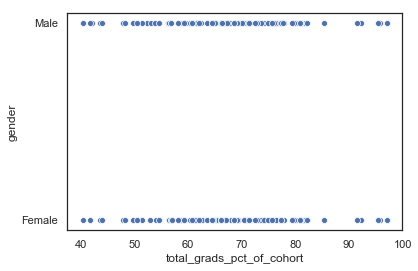

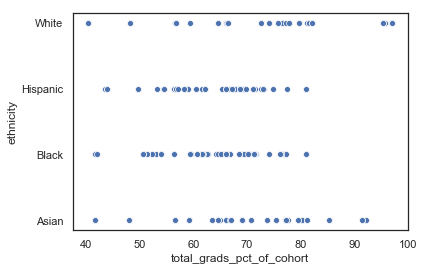

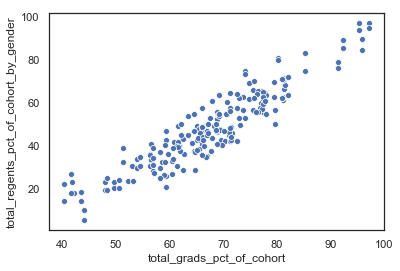

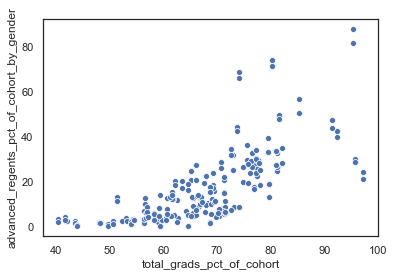

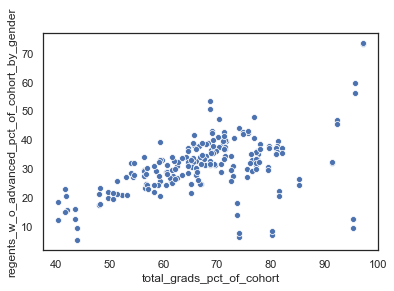

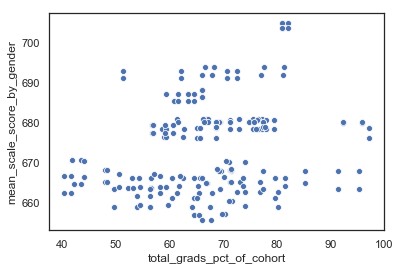

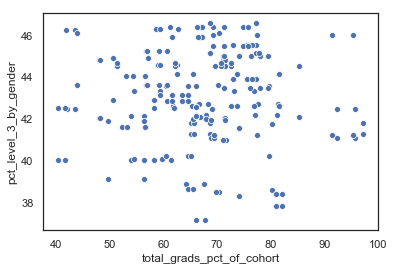

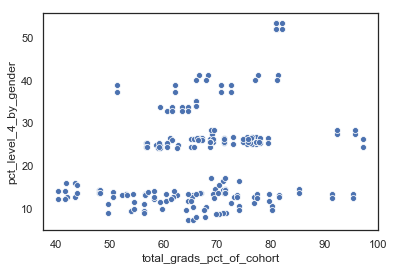

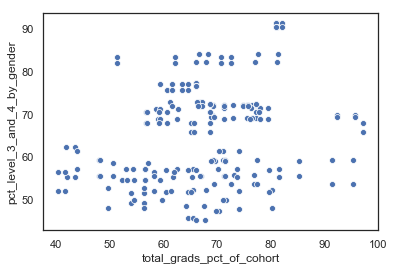

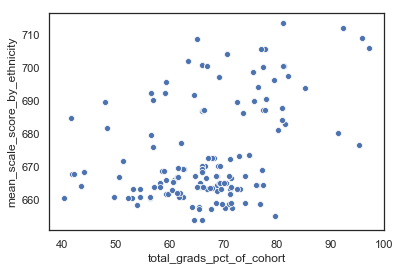

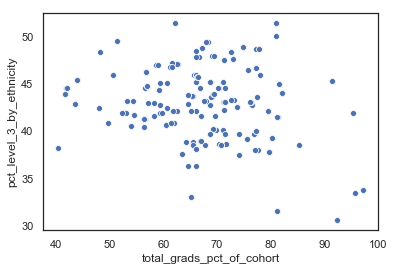

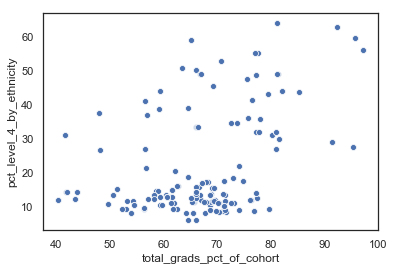

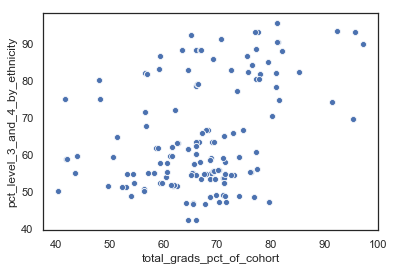

In [81]:
# 2-var Scatter Plots with 'total_grads_pct_of_cohort_by_gender' & col
for i, col in enumerate(df2.columns):
#     print(i, col)
    if col != 'total_grads_pct_of_cohort':
        plt.figure(i)
        sns.scatterplot(x=df2['total_grads_pct_of_cohort'],y=df2[col], data=df2)

Basic Regression Diagnostics
----------------------------
Slope: 0.28
Y-Intercept: 49.47
R-Squared: 0.07
----------------------------
Model: Y = 0.28 * X + 49.47


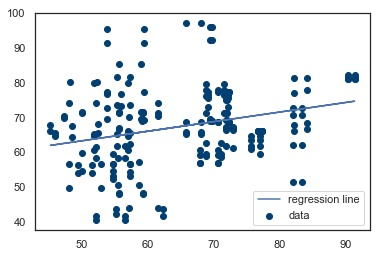

In [82]:
# slr plot against feature with highest coefficient and lowest p-value

X = np.array(df2['pct_level_3_and_4_by_gender'].tolist(), dtype=np.float64)
Y = np.array(df2['total_grads_pct_of_cohort'].tolist(), dtype=np.float64)

def calc_slope(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)**2) - np.mean(xs*xs)))
    return m

def best_fit(xs,ys):
    m = calc_slope(xs,ys)
    b = np.mean(ys) - m*np.mean(xs)
    return m, b

def reg_line (m, b, X):
    return [(m*x)+b for x in X]

def sum_sq_err(ys_real,ys_predicted):
    sse =  sum((ys_predicted - ys_real) * (ys_predicted - ys_real))
    return sse

def r_squared(ys_real, ys_predicted):
    # Calculate Y_mean , squared error for regression and mean line , and calculate r-squared
    y_mean = [np.mean(ys_real) for y in ys_real]
    sq_err_reg= sum_sq_err(ys_real, ys_predicted)
    sq_err_y_mean = sum_sq_err(ys_real, y_mean)
    # Calculate r-squared 
    r_sq =  1 - (sq_err_reg/sq_err_y_mean)
    return r_sq

def plot_reg(X,Y,Y_pred):
    plt.scatter(X,Y,color='#003F72',label='data')
    plt.plot(X, Y_pred, label='regression line')
    plt.legend(loc=4)
    plt.show()
    return None

m, b = best_fit(X,Y)
Y_pred = reg_line(m, b, X)
r_squared = r_squared(Y,Y_pred)

print ('Basic Regression Diagnostics')
print ('----------------------------')
print ('Slope:', round(m,2))
print ('Y-Intercept:', round(b,2))
print ('R-Squared:', round(r_squared,2))
print ('----------------------------')
print ('Model: Y =',round(m,2),'* X +', round(b,2))

plot_reg(X,Y,Y_pred)

In [83]:
# checking for our model - Homoscedasticity
pred_val = mod2.fittedvalues.copy()
true_val = df2['total_grads_pct_of_cohort'].values.copy()
residual = true_val - pred_val

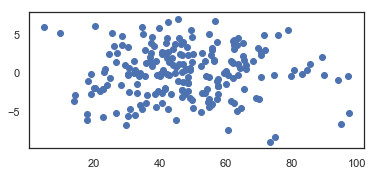

In [84]:
# Residual Plot Graph
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(df2['total_regents_pct_of_cohort_by_gender'],residual)

((array([-2.71998712, -2.41245805, -2.23735559, -2.11206521, -2.01315235,
         -1.9307308 , -1.85965679, -1.79689779, -1.74050949, -1.68916746,
         -1.64192721, -1.5980905 , -1.55712595, -1.51861937, -1.48224137,
         -1.44772552, -1.41485308, -1.38344218, -1.35333989, -1.32441631,
         -1.29656016, -1.2696753 , -1.24367809, -1.2184953 , -1.1940624 ,
         -1.17032226, -1.147224  , -1.12472213, -1.10277578, -1.0813481 ,
         -1.06040575, -1.03991844, -1.01985857, -1.00020091, -0.98092235,
         -0.96200163, -0.94341919, -0.92515694, -0.90719814, -0.88952727,
         -0.87212989, -0.85499255, -0.83810272, -0.82144864, -0.80501935,
         -0.78880453, -0.7727945 , -0.75698015, -0.74135288, -0.72590461,
         -0.71062766, -0.69551479, -0.68055913, -0.66575417, -0.65109372,
         -0.63657189, -0.62218309, -0.60792196, -0.59378342, -0.57976259,
         -0.56585482, -0.55205565, -0.53836082, -0.52476621, -0.51126791,
         -0.49786214, -0.48454524, -0.

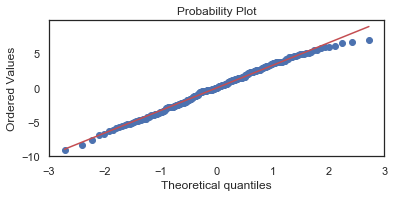

In [85]:
# checking for normality - QQ plot 
fig, ax = plt.subplots(figsize=(6,2.5))
sp.stats.probplot(residual, plot=ax, fit=True)


In [86]:
# Testing predicability of model with actual values

X = df2.drop(columns=['total_grads_pct_of_cohort','gender','ethnicity'], axis=1)
y = df2[['total_grads_pct_of_cohort']]

# Changing fit_intercept to True makes coefficient values aligned to previous regression model
sklearnmodel = LinearRegression(fit_intercept=True).fit(X, Y)
r_squared = sklearnmodel.score(X, Y)

# Plugging in x values for district = '1'
predict = sklearnmodel.predict(np.array([[60.36, 13.19, 47.16, 677.29, 41.53, 25.36, 66.9, 
                                          685.54, 38.85, 34.25, 73.09]])) 
print("Coefficients: ", sklearnmodel.coef_)
print("R2: ", r_squared)
print("Prediction: ", predict)

Coefficients:  [ -27.5910199    28.19009564   28.36950427   -3.36789095 -151.66587458
 -149.85911104  153.34496602   -0.67724038   62.61250046   62.97488694
  -62.2683991 ]
R2:  0.9014431613662932
Prediction:  [78.93722552]


In [87]:
# Prediction above was 78.94%
# Actual dataset value 74.13%
# Less than 5% difference from predicted and actual values

df.groupby('district')['total_grads_pct_of_cohort',
                       'total_regents_pct_of_cohort_by_gender',
                       'advanced_regents_pct_of_cohort_by_gender',
                       'regents_w_o_advanced_pct_of_cohort_by_gender',
                       'mean_scale_score_by_gender',
                       'pct_level_3_by_gender',
                       'pct_level_4_by_gender',
                       'pct_level_3_and_4_by_gender',
                       'mean_scale_score_by_ethnicity',
                       'pct_level_3_by_ethnicity',
                       'pct_level_4_by_ethnicity',
                       'pct_level_3_and_4_by_ethnicity'].mean().head(1)


,total_grads_pct_of_cohort,total_regents_pct_of_cohort_by_gender,advanced_regents_pct_of_cohort_by_gender,regents_w_o_advanced_pct_of_cohort_by_gender,mean_scale_score_by_gender,pct_level_3_by_gender,pct_level_4_by_gender,pct_level_3_and_4_by_gender,mean_scale_score_by_ethnicity,pct_level_3_by_ethnicity,pct_level_4_by_ethnicity,pct_level_3_and_4_by_ethnicity
district,,,,,,,,,,,,
1,74.132826,60.360831,13.196797,47.163079,677.297619,41.538095,25.363095,66.895238,685.541667,38.850595,34.249405,73.095833
